In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving touch_data (2).csv to touch_data (2).csv
User uploaded file "touch_data (2).csv" with length 28332692 bytes


In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, Lambda, Concatenate, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

In [25]:
df=pd.read_csv('touch_data (2).csv', delimiter=',')
df.shape

(43735, 15)

In [26]:
df.head(5)

,participant_id,task_id,trial_id,timestamp_ms,ref_char,ref_char_index_in_prompt,first_frame_touch_x,first_frame_touch_y,first_frame_touch_major,first_frame_touch_minor,first_frame_touch_orientation,first_frame_touch_heatmap,first_frame_heatmap_overlap_vector,was_deleted,lm_scores
0,user01,task1,0,239529639,m,0,1108.0,519.0,152.0,117.0,0.086670,"[[8, 13, 20], [8, 14, 18], [9, 13, 203], [9, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,NaN
1,user01,task1,0,239530001,y,1,757.0,145.0,172.0,164.0,-0.220893,"[[3, 8, 10], [3, 9, 14], [3, 10, 10], [4, 8, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.0771875, 35.689375...",False,"[0.280352, 0.000941453, 0.0130359, 0.00083572,..."
2,user01,task1,0,239530213,SPACE,2,722.0,676.0,191.0,174.0,0.844456,"[[10, 7, 10], [10, 8, 44], [10, 9, 55], [10, 1...","[0.0, 47.33625, 34.07749999999999, 0.0, 0.0, 0...",False,"[0.00334769, 7.19902e-05, 0.00282896, 4.7261e-..."
3,user01,task1,0,239530547,p,3,1321.0,150.0,167.0,154.0,-1.547403,"[[4, 15, 34], [4, 16, 77], [4, 17, 26], [5, 15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False,"[0.0429174, 0.136679, 0.0615558, 0.0696998, 0...."
4,user01,task1,0,239530672,r,4,550.0,152.0,179.0,126.0,-0.041801,"[[3, 6, 13], [4, 6, 79], [4, 7, 67], [5, 6, 16...","[0.0, 0.0, 0.0, 16.288125, 0.0, 44.91187499999...",False,"[0.170914, 0.0, 0.00728994, 0.000328849, 0.044..."


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43735 entries, 0 to 43734
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   participant_id                      43735 non-null  object 
 1   task_id                             43735 non-null  object 
 2   trial_id                            43735 non-null  int64  
 3   timestamp_ms                        43735 non-null  int64  
 4   ref_char                            43735 non-null  object 
 5   ref_char_index_in_prompt            43735 non-null  int64  
 6   first_frame_touch_x                 43735 non-null  float64
 7   first_frame_touch_y                 43735 non-null  float64
 8   first_frame_touch_major             43735 non-null  float64
 9   first_frame_touch_minor             43735 non-null  float64
 10  first_frame_touch_orientation       43735 non-null  float64
 11  first_frame_touch_heatmap           43735

In [28]:
int(df.duplicated().sum())

0

In [29]:
df.isnull().sum()

,0
participant_id,0
task_id,0
trial_id,0
timestamp_ms,0
ref_char,0
ref_char_index_in_prompt,0
first_frame_touch_x,0
first_frame_touch_y,0
first_frame_touch_major,0
first_frame_touch_minor,0


In [30]:
df = df.dropna()

In [31]:
import ast
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
def parse_overlap_vector(vector_str):
    try:
        vec = ast.literal_eval(vector_str)
        return vec + [0.0] * (28 - len(vec)) if len(vec) < 28 else vec[:28]
    except:
        return [0.0] * 28

df["parsed_overlap_vector"] = df["first_frame_heatmap_overlap_vector"].apply(parse_overlap_vector)

def build_feature_vector(row):
    basic = [
        row["first_frame_touch_x"],
        row["first_frame_touch_y"],
        row["first_frame_touch_major"],
        row["first_frame_touch_minor"],
        row["first_frame_touch_orientation"]
    ]
    return np.array(basic + row["parsed_overlap_vector"])

df["feature_vector"] = df.apply(build_feature_vector, axis=1)

# Normalize features per user
user_feature_dict = defaultdict(list)
for _, row in df.iterrows():
    user_feature_dict[row["participant_id"]].append(row["feature_vector"])

normalized_user_features = {}
for user, vectors in user_feature_dict.items():
    vectors = np.stack(vectors)
    scaler = StandardScaler()
    normalized_user_features[user] = scaler.fit_transform(vectors)


In [32]:
import random
random.seed(42)
np.random.seed(42)
positive_pairs, negative_pairs = [], []
users = list(normalized_user_features.keys())
num_pairs = 10000

for _ in range(num_pairs):
    user = random.choice(users)
    samples = normalized_user_features[user]
    if len(samples) >= 2:
        i, j = np.random.choice(len(samples), 2, replace=False)
        positive_pairs.append((samples[i], samples[j], 1))

for _ in range(num_pairs):
    user1, user2 = random.sample(users, 2)
    vec1 = random.choice(normalized_user_features[user1])
    vec2 = random.choice(normalized_user_features[user2])
    negative_pairs.append((vec1, vec2, 0))

pairs = positive_pairs + negative_pairs
random.shuffle(pairs)
X1 = np.array([p[0] for p in pairs])
X2 = np.array([p[1] for p in pairs])
y = np.array([p[2] for p in pairs])

In [33]:
def create_siamese_model(input_shape):
    def base_network(input_shape):
        inp = Input(shape=input_shape)
        x = layers.Reshape((input_shape[0], 1))(inp)
        x = layers.LSTM(64)(x)
        x = layers.Dense(64, activation='relu')(x)
        return Model(inp, x)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    base_net = base_network(input_shape)
    out_a = base_net(input_a)
    out_b = base_net(input_b)

    diff = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([out_a, out_b])
    output = layers.Dense(1, activation='sigmoid')(diff)

    model = Model([input_a, input_b], output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [36]:
model = create_siamese_model((33,))
history = model.fit([X1, X2], y, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5034 - loss: 0.6937 - val_accuracy: 0.5073 - val_loss: 0.6931
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5120 - loss: 0.6932 - val_accuracy: 0.4940 - val_loss: 0.6937
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5000 - loss: 0.6934 - val_accuracy: 0.4870 - val_loss: 0.6931
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5106 - loss: 0.6932 - val_accuracy: 0.5642 - val_loss: 0.6931
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5373 - loss: 0.6928 - val_accuracy: 0.5955 - val_loss: 0.6922
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6027 - loss: 0.6911 - val_accuracy: 0.6965 - val_loss: 0.6766
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6900 - loss: 0.6638 - val_accuracy: 0.7125 - val_loss: 0.6158
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7169 - loss: 0.6197 - 

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred_prob = model.predict([X1, X2])
y_pred = (y_pred_prob >= 0.65).astype(int)

acc = accuracy_score(y, y_pred)
auc = roc_auc_score(y, y_pred_prob)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f"\nAccuracy @ 65% threshold: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

Accuracy @ 65% threshold: 0.6341
AUC: 0.8270
Precision: 0.8586
Recall: 0.3212
F1 Score: 0.4675



Confusion Matrix:
[[9471  529]
 [6788 3212]]


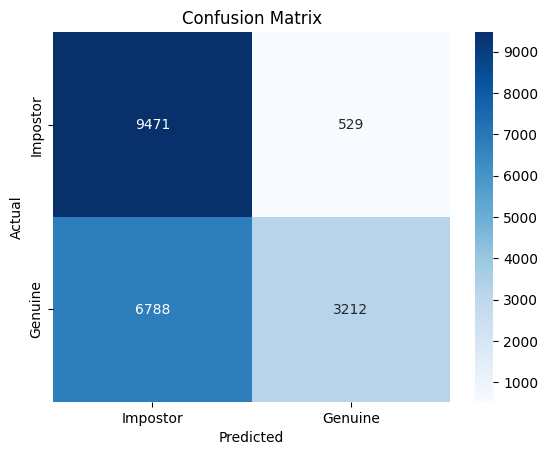

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Impostor", "Genuine"], yticklabels=["Impostor", "Genuine"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


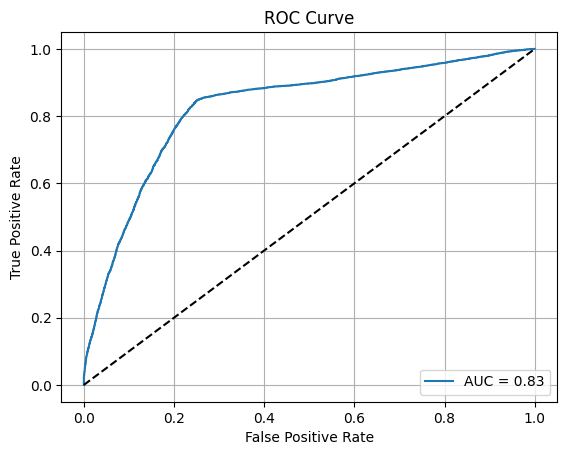

In [39]:
fpr, tpr, _ = roc_curve(y, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<ipython-input-40-3302032193>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='viridis')


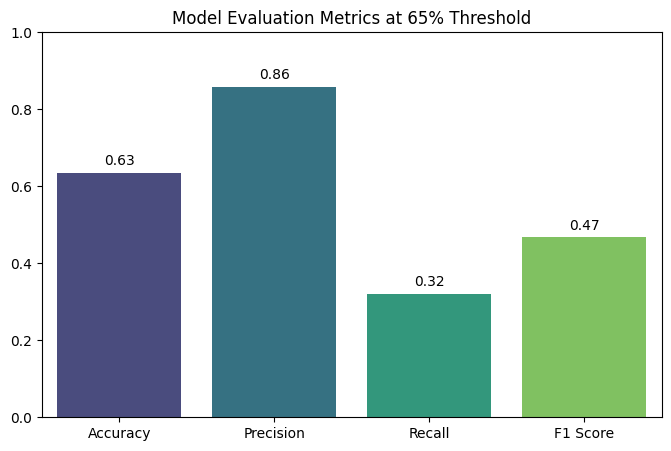

In [40]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [acc, precision, recall, f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=scores, palette='viridis')
plt.ylim(0, 1)
plt.title("Model Evaluation Metrics at 65% Threshold")
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()